<a href="https://colab.research.google.com/github/Badih-sab/Detect_hard_hats/blob/main/Detect_hard_hats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ultralytics
!pip install opencv-python matplotlib roboflow
!pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 126.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [1]:
# 1. Install Kaggle API
!pip install kaggle

# 2. Upload your Kaggle API key (kaggle.json)
from google.colab import files
print("🔑 Please upload your kaggle.json file")
uploaded = files.upload()  # <-- choose the kaggle.json file you downloaded from Kaggle

# 3. Put kaggle.json in the correct folder
import os
if uploaded:
  for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')
    !mkdir -p ~/.kaggle
    !cp "{fn}" ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

# 4. Download the Hard Hat Detection dataset from Kaggle
!kaggle datasets download -d andrewmvd/hard-hat-detection

# 5. Unzip the dataset
!unzip -q hard-hat-detection.zip -d hard_hat_dataset

print("✅ Dataset downloaded and extracted into 'hard_hat_dataset' folder")

🔑 Please upload your kaggle.json file


Saving hard-hat-detection-metadata.json to hard-hat-detection-metadata.json
User uploaded file "hard-hat-detection-metadata.json"
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open hard-hat-detection.zip, hard-hat-detection.zip.zip or h

In [2]:
import kagglehub
import pandas as pd
import os
import xml.etree.ElementTree as ET # Import ElementTree

# Download latest version
dataset_path = kagglehub.dataset_download("andrewmvd/hard-hat-detection")

print("Path to dataset files:", dataset_path)

# Load the annotations into a pandas DataFrame
annotations_path = os.path.join(dataset_path, "annotations")
data = []

# Parse each XML annotation file
for file in os.listdir(annotations_path):
    if file.endswith(".xml"):
        xml_path = os.path.join(annotations_path, file)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        filename = root.find("filename").text
        for obj in root.findall("object"):
            label = obj.find("name").text
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            data.append([filename, label, xmin, ymin, xmax, ymax])

# Make a DataFrame
df = pd.DataFrame(data, columns=["filename", "label", "xmin", "ymin", "xmax", "ymax"])

# Show first rows
display(df.head(10))

Using Colab cache for faster access to the 'hard-hat-detection' dataset.
Path to dataset files: /kaggle/input/hard-hat-detection


filename   label  xmin  ymin  xmax  ymax
0  hard_hat_workers1531.png  helmet    90   104   114   131
1  hard_hat_workers1531.png  helmet   109   107   133   135
2  hard_hat_workers1531.png  helmet   310   185   329   208
3  hard_hat_workers1531.png  helmet    90     8   114    35
4  hard_hat_workers1531.png  helmet   109     3   133    31
5  hard_hat_workers4092.png  helmet   229   122   303   208
6  hard_hat_workers4092.png  person   188   130   368   356
7  hard_hat_workers4092.png  person   188   359   369   414
8  hard_hat_workers2006.png  helmet    58   103   228   288
9  hard_hat_workers3414.png  helmet   125   177   155   213

In [3]:
from ultralytics import YOLO

# Load pre-trained YOLOv5 small model
model = YOLO('yolov5s.pt')  # official pre-trained weights


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



In [4]:
import os
import shutil
import cv2
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

classes = ['helmet','no-helmet']  # 0=helmet, 1=no-helmet

base_path = "hard_hat_dataset_yolo"
for split in ['train','val','test']:
    os.makedirs(os.path.join(base_path,'images',split), exist_ok=True)
    os.makedirs(os.path.join(base_path,'labels',split), exist_ok=True)

images_path = os.path.join(dataset_path,"images")
all_images = [f for f in os.listdir(images_path) if f.endswith(".jpg") or f.endswith(".png")]

train_imgs, temp_imgs = train_test_split(all_images, test_size=0.3, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.33, random_state=42)

split_dict = {'train': train_imgs, 'val': val_imgs, 'test': test_imgs}

def convert_to_yolo(xml_file, img_width, img_height):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = root.findall("object")
    yolo_data = []
    for obj in objects:
        name = obj.find("name").text.lower()

        # Map 'person' → 'no-helmet'
        if name == "person":
            name = "no-helmet"

        if name not in classes:
            continue

        cls_id = classes.index(name)
        bbox = obj.find("bndbox")
        x_center = (int(bbox.find("xmin").text) + int(bbox.find("xmax").text)) / 2 / img_width
        y_center = (int(bbox.find("ymin").text) + int(bbox.find("ymax").text)) / 2 / img_height
        width = (int(bbox.find("xmax").text) - int(bbox.find("xmin").text)) / img_width
        height = (int(bbox.find("ymax").text) - int(bbox.find("ymin").text)) / img_height
        yolo_data.append([cls_id, x_center, y_center, width, height])
    return yolo_data

#  Process images and XMLs
for split, img_list in split_dict.items():
    for img_name in img_list:
        # Image path
        src_img_path = os.path.join(images_path,img_name)
        dst_img_path = os.path.join(base_path,'images',split,img_name)
        shutil.copy(src_img_path, dst_img_path)

        # XML path
        xml_name = img_name.replace(".jpg",".xml").replace(".png",".xml")
        xml_path = os.path.join(dataset_path,"annotations",xml_name)
        if not os.path.exists(xml_path):
            continue

        # Image size
        img = cv2.imread(src_img_path)
        h, w = img.shape[:2]

        # Convert annotation
        yolo_boxes = convert_to_yolo(xml_path,w,h)
        if not yolo_boxes:
            continue

        # Save YOLO txt
        txt_name = os.path.splitext(img_name)[0]+".txt"
        txt_path = os.path.join(base_path,'labels',split,txt_name)
        with open(txt_path,'w') as f:
            for box in yolo_boxes:
                f.write(" ".join([str(x) for x in box]) + "\n")

print("✅ Dataset converted to YOLO format!")

# Create data.yaml
yaml_content = f"""
train: {os.path.abspath(os.path.join(base_path,'images','train'))}
val: {os.path.abspath(os.path.join(base_path,'images','val'))}

nc: {len(classes)}
names: {classes}
"""

with open('data.yaml','w') as f:
    f.write(yaml_content)

print("✅ data.yaml created!")




✅ Dataset converted to YOLO format!
✅ data.yaml created!


In [6]:

from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # or yolov8s.pt

model.train(
    data='data.yaml',      # updated dataset with augmented images
    epochs=15,             # or fewer for testing
    imgsz=416,
    batch=8,
    project='runs/train',
    name='helmet_exp_aug',  # new experiment name
    exist_ok=True
)



Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=helmet_exp_aug, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrai

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x782eb58788c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [10]:
from ultralytics import YOLO

# Load trained model
model = YOLO('/content/runs/train/helmet_exp_aug/weights/best.pt')  # use your latest trained weights

# Predict and show
model.predict('helemet_picture.webp', show=True, save=True)





image 1/1 /content/helemet_picture.webp: 416x416 7 helmets, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)
Results saved to /content/runs/detect/predict2


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'helmet', 1: 'no-helmet'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 84, 104, 107],
         [103, 122, 126],
         [108, 127, 131]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 55,  74,  78],
         [ 69,  88,  92],
         [ 84, 104, 107]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 77,  94,  98],
         [ 68,  85,  89],
         [ 76,  93,  97]],
 
        ...,
 
        [[184, 217, 239],
         [188, 222, 244],
         [190, 223, 245],
         ...,
         [176, 218, 250],
         [175, 216, 248],
         [174, 215, 247]],
 
        [[181, 215, 237],
         [185, 219, 240],
         [183, 216, 238],
         ...,
  

For example, here we download and display a PNG image of the Colab logo:

In [21]:
import  matplotlib.pyplot as plt


image 1/1 /content/helemet_picture.webp: 416x416 7 helmets, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)


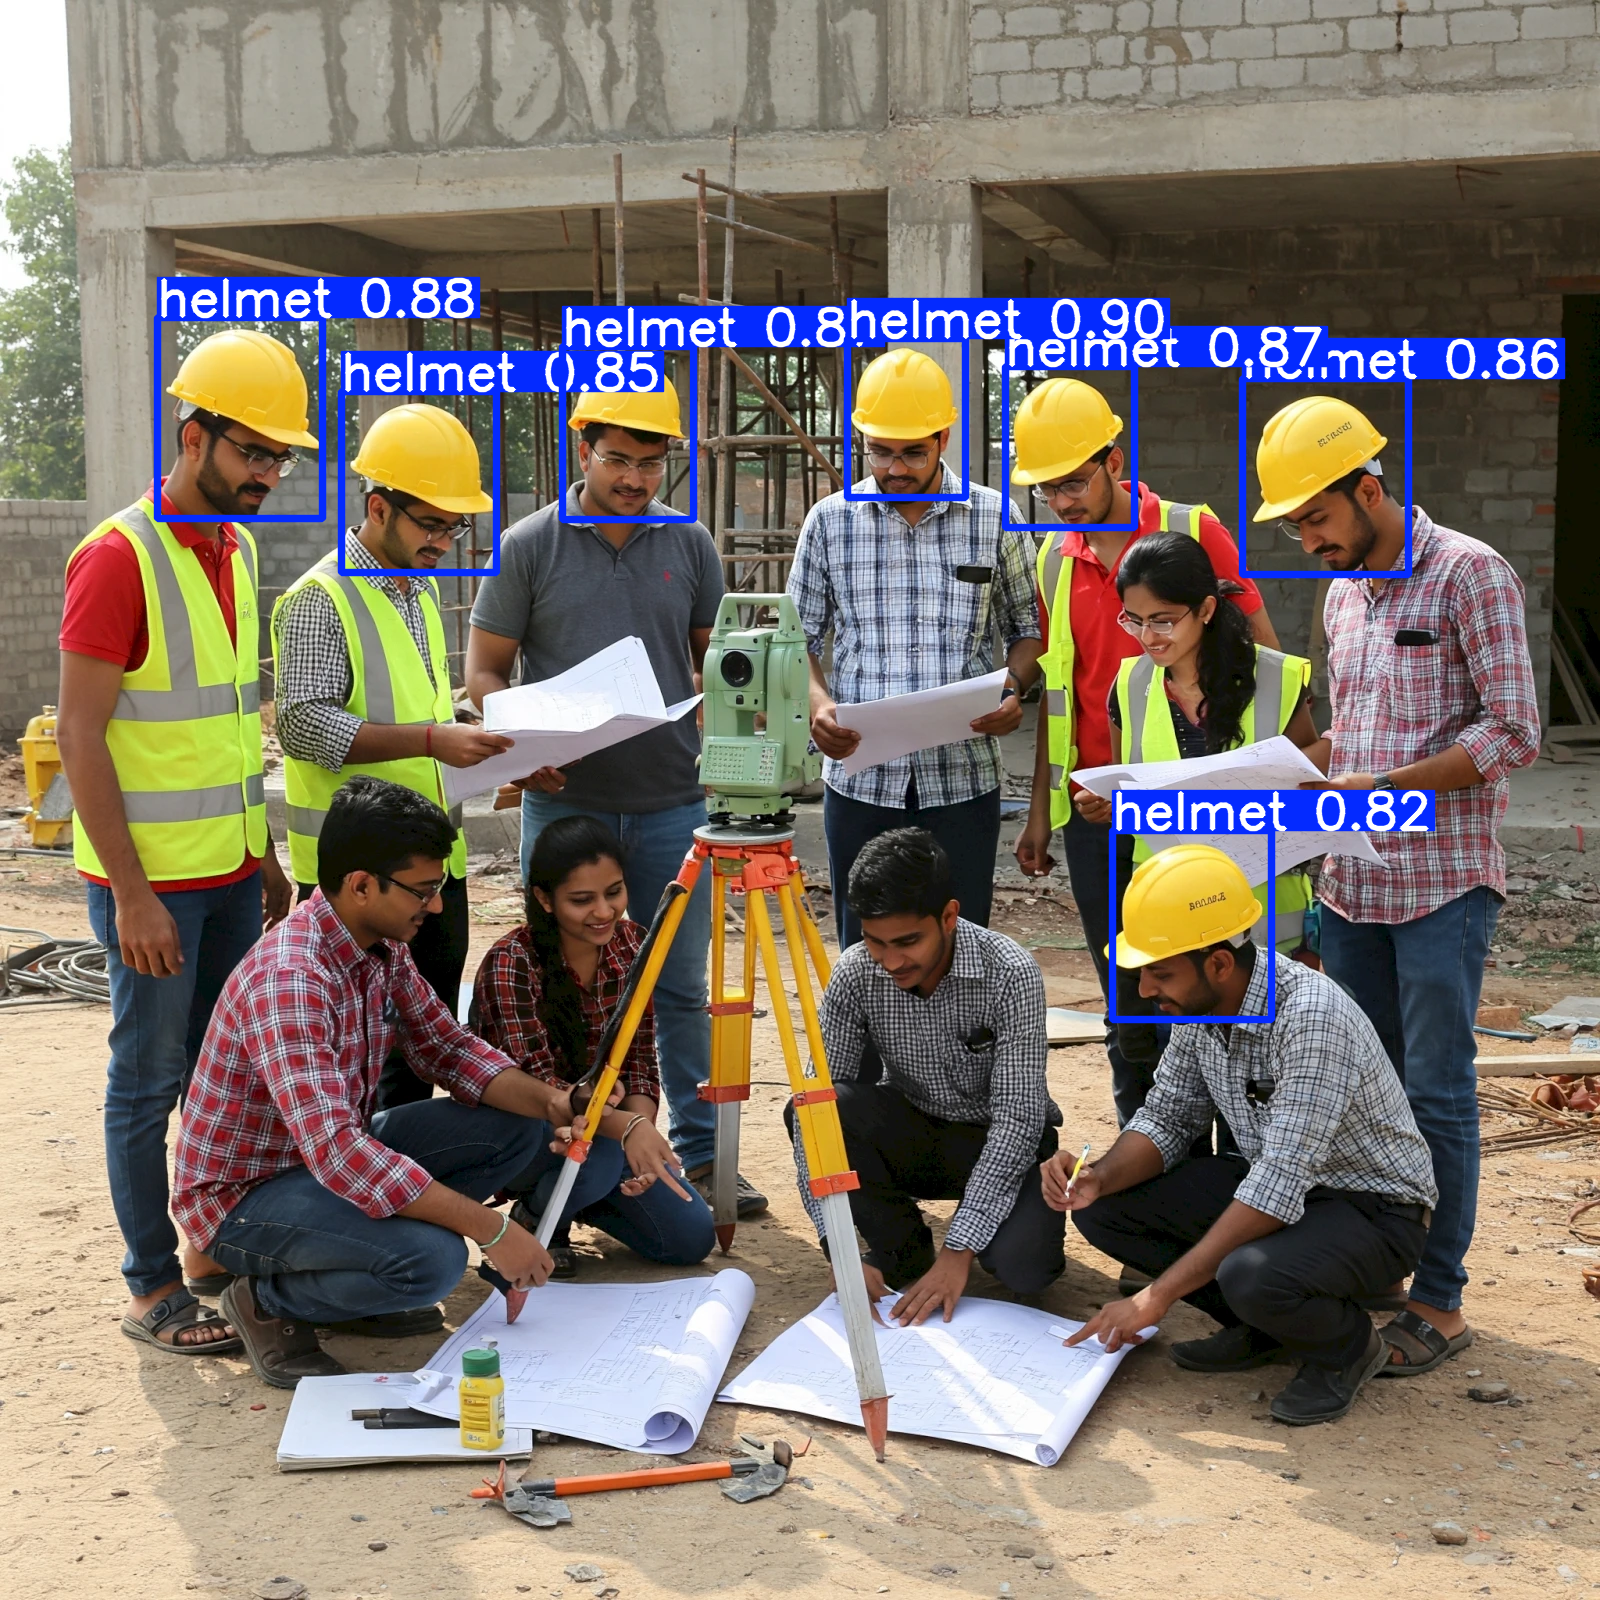

In [26]:
from ultralytics import YOLO

# Load trained model
model = YOLO('/content/runs/train/helmet_exp_aug/weights/best.pt')

# Test on one image
results = model('helemet_picture.webp')
results[0].show()




image 1/1 /content/images22.jpg: 288x416 2 helmets, 38.5ms
Speed: 1.0ms preprocess, 38.5ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 416)


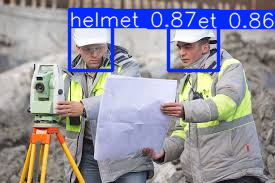

In [12]:
from ultralytics import YOLO

# Load trained model
model = YOLO('/content/runs/train/helmet_exp_aug/weights/best.pt')

# Test on one image
results = model('images22.jpg')
results[0].show()

In [59]:
import cv2
from ultralytics import YOLO
from moviepy.editor import ImageSequenceClip
import os # Import os

# Load YOLO model
model = YOLO('/content/runs/train/helmet_exp_aug/weights/best.pt')  # your trained helmet model

# Path to the video file
video_path = 'helemet_video.mp4' # Corrected filename

# Check if the video file exists
if not os.path.exists(video_path):
    print(f"Error: Video file not found at {video_path}")
else:
    # Open video
    cap = cv2.VideoCapture(video_path)

    # Check if video capture was successful
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
    else:
        frames = []
        fps = cap.get(cv2.CAP_PROP_FPS)
        if fps == 0 or fps is None:
            fps = 20  # default FPS if detection fails

        # Read and process frames
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Run YOLO inference
            results = model(frame, verbose=False) # Set verbose to False to reduce output

            # Draw detections
            for result in results:
                for box in result.boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                    cls = int(box.cls[0])
                    conf = float(box.conf[0])
                    label = f"{result.names[cls]} {conf:.2f}"

                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(frame, label, (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert to RGB for MoviePy

        cap.release()

        # Save video using MoviePy ImageSequenceClip
        if frames: # Only create clip if there are frames
            clip = ImageSequenceClip(frames, fps=fps)
            clip.write_videofile("output.mp4")
            print("✅ Finished — saved as output.mp4")
        else:
            print("No frames were read from the video file.")

Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4
✅ Finished — saved as output.mp4


In [60]:
from IPython.display import Video

# Show the processed video in the notebook
Video("output.mp4", embed=True)
